In [1]:
%load_ext autoreload
%autoreload 2

# Deep Gaussian Markov Random Fields on lattice (the original DGMRFs on images)

Original code can be found [here](https://bitbucket.org/psiden/deepgmrf/src/master/main_script.py). And the article is [here](http://proceedings.mlr.press/v119/siden20a/siden20a.pdf).

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]=""

from functools import partial
from torch.distributions import MultivariateNormal
import torch
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx
import numpy as np


key = jax.random.PRNGKey(0)

In [3]:
try:
    gpu_device = jax.devices('gpu')[0]
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device, gpu_device)
except:
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device)

TFRT_CPU_0 cuda:0


## First create some observations
We sample a GMRF with Cholesky sampling

In [4]:
H = 50
W = 50
r = 10

In [5]:
from dgmrf.utils import cholesky_sampling_gaussian_field
key, subkey = jax.random.split(key)
source_term = jax.random.normal(subkey, shape=(H * W,))

with jax.default_device(cpu_device):
    x_ori = cholesky_sampling_gaussian_field(r, source_term.flatten(), H, W)

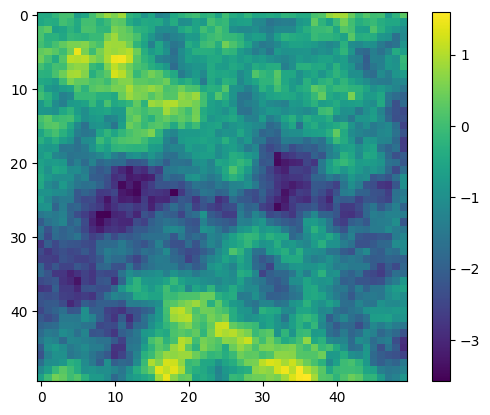

In [6]:
plt.imshow(x_ori)
plt.colorbar()
plt.show()

Add noise over the observations

In [7]:
key, subkey = jax.random.split(key)
true_sigma_noise = 0.01
y = x_ori + jax.random.normal(subkey, x_ori.shape) * true_sigma_noise
N = H * W

In [8]:
y = jnp.pad(y, 10)

In [9]:
mask = jnp.zeros_like(y)
mask = mask.at[:10, :].set(1)
mask = mask.at[-10:, :].set(1)
mask = mask.at[:, -10:].set(1)
mask = mask.at[:, :10].set(1)

mask = mask.at[25:50, 35:40].set(1)
H += 20
W += 20
N = H * W
y = jnp.where(mask == 0, y, 0)

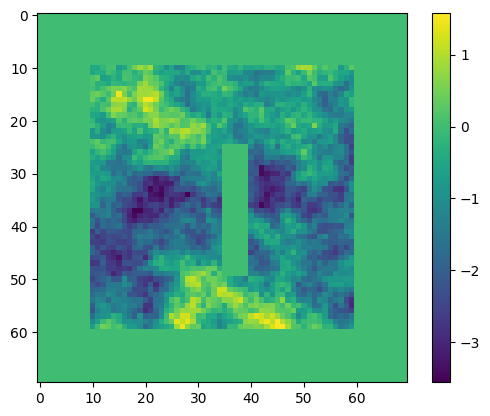

In [10]:
plt.imshow(y)
plt.colorbar()
plt.show()

## Define the DGMRF
In the supplementary material of Siden 2020 they claim that the biases are fixed to 0.

In [11]:
from dgmrf.models import DGMRF
from dgmrf.utils import get_adjacency_matrix_lattice

In [12]:
L = 3
Nq = 10

In [13]:
y = y.flatten()
mask = mask.flatten()

In [14]:
key, subkey = jax.random.split(key, 2)

dgmrf = DGMRF(subkey, L, height_width=(H, W), with_bias=True)

dgmrf_params, dgmrf_static = eqx.partition(dgmrf, lambda x:eqx.is_inexact_array(x)) # and not eqx.is_exact because the layer would consider self.key as a parameter!

## Variational inference to compute model parameters

The initial values of the mean and std for the variational distribution are given lines 572 and 573 of the orignal code.

In [15]:
key, subkey1, subkey2 = jax.random.split(key, 3)
params_init = {
    "dgmrf":dgmrf_params,
    "log_sigma":jnp.log(true_sigma_noise),
    "nu_phi":jax.random.normal(subkey1, (N,)) * 1,
    "log_S_phi":jax.nn.softplus(jax.random.normal(subkey2, (N,)) * 0.01), # jnp.ones((H * W,)) * 1
}
static = {
    "dgmrf": dgmrf_static
}


In [16]:
n_iter = 1000
lr_conv = 1e-2

lr = lr_conv
tx = optax.multi_transform(
    {
     'dgmrf': optax.adam(lr), 'log_sigma': optax.adam(0),
     'nu_phi': optax.adam(lr), 'log_S_phi': optax.adam(lr)},
    {'dgmrf':"dgmrf", 'log_sigma':'log_sigma', 'nu_phi':'nu_phi', 'log_S_phi':'log_S_phi'} # This what would be returned by the label_fn; i.e. this is the correct syntax when directly giving labels and when params is dict
)
opt_state = tx.init(params_init)

In [17]:
dgmrf = eqx.combine(params_init["dgmrf"], static["dgmrf"])

In [18]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

key, subkey = jax.random.split(key, 2)
params_final, loss_val = train_loop(dgmrf_elbo, y, n_iter, params_init, static, tx, opt_state, subkey, N, Nq, mask)

  0%|          | 0/1000 [00:00<?, ?it/s]

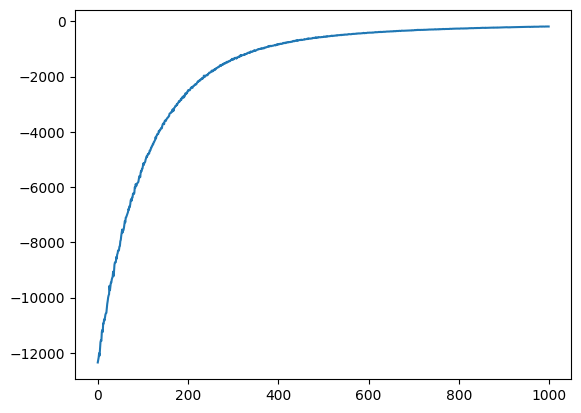

In [19]:
plt.plot(-loss_val)
plt.show()

TypeError: sub got incompatible shapes for broadcasting: (70, 70), (50, 50).

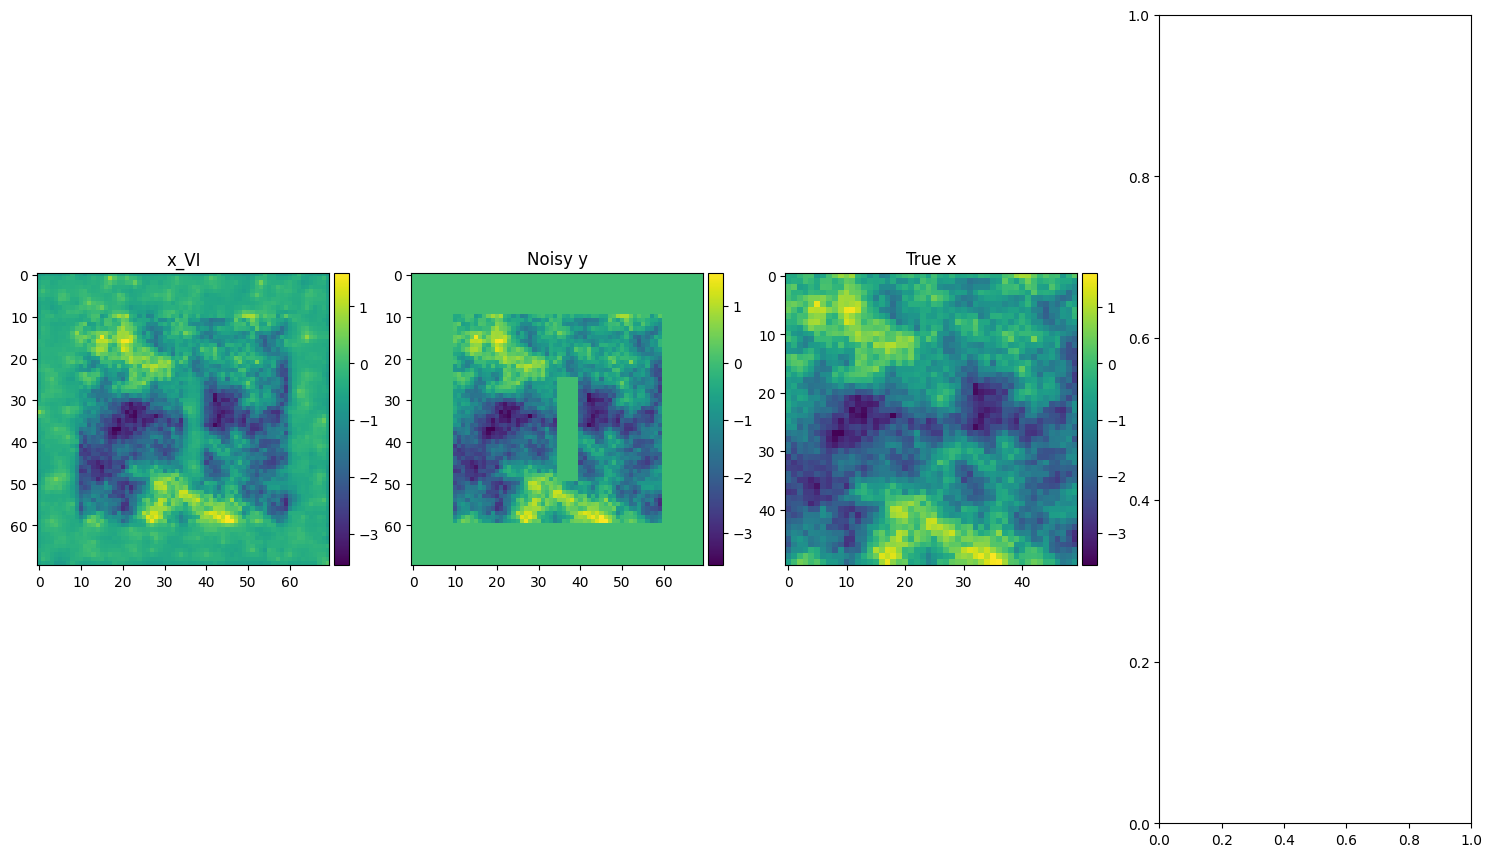

In [20]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(params_final["nu_phi"].reshape(H, W))
axes[0].set_title("x_VI")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[3].imshow(jnp.abs(params_final["nu_phi"].reshape(H, W) - x_ori))
divider = make_axes_locatable(axes[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axes[3].set_title("|x_VI - x|")

plt.show()

## Analyze the filters

Params for layer l=0 [ 1.0234106e+00 -7.0036522e-06 -5.0940660e-05 -4.7969379e-06
 -7.7135504e-05  3.9855474e-01]
Params for layer l=1 [ 7.8453857e-01 -1.4491491e-05 -2.6052703e-05 -1.1805713e-05
 -1.8758861e-05  6.0077924e-01]
Params for layer l=2 [ 1.5693173  -0.37067994 -0.14467596 -0.16256642 -0.42443195 -0.18708117]


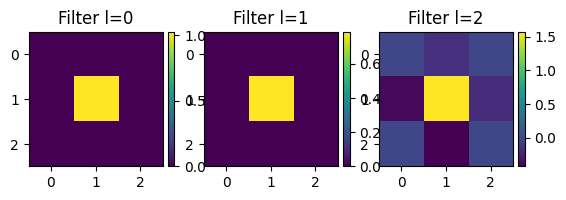

In [21]:
from dgmrf.layers import ConvLayer
fig.set_size_inches(30.5, 15.5)

fig, axes = plt.subplots(1, L + 1 if L == 1 else L)
for l in range(L):
    f1_ = ConvLayer.params_transform(params_final["dgmrf"].layers[l].params)
    print(f"Params for layer {l=}", ConvLayer.params_transform(params_final["dgmrf"].layers[l].params))
    f1 = jnp.array([[0, f1_[2], 0], [f1_[1], f1_[0], f1_[3]], [0, f1_[4], 0]])
    im = axes[l].imshow(f1)
    axes[l].set_title(f"Filter {l=}")
    divider = make_axes_locatable(axes[l])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

## Posterior mean computation with conjugate gradient

In [22]:
dgmrf = eqx.combine(params_final["dgmrf"], static["dgmrf"])

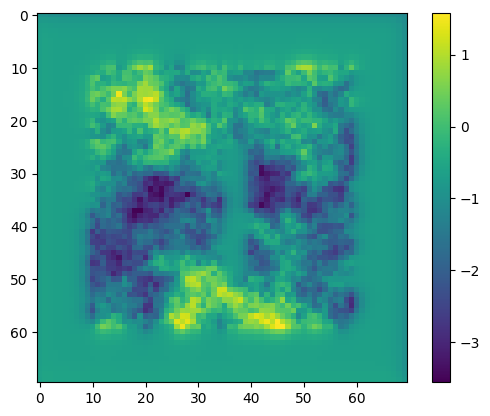

[[ 7.8386003e-01  3.1856263e-01  1.0654091e-01 ... -1.4012985e-45
  -1.4012985e-45 -1.4012985e-45]
 [ 3.1856263e-01  9.0832829e-01  3.6132222e-01 ... -1.4012985e-45
  -1.4012985e-45 -1.4012985e-45]
 [ 1.0654093e-01  3.6132225e-01  9.2365408e-01 ... -1.4012985e-45
  -1.4012985e-45 -1.4012985e-45]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  8.2247037e-01
   2.9941827e-01  8.6670943e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.9941827e-01
   8.2004583e-01  2.8617254e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  8.6670935e-02
   2.8617254e-01  7.6310933e-01]]


In [23]:
Q = dgmrf.get_Q()
QTilde = Q + jnp.diag(1/(jnp.exp(params_final["log_sigma"])**2) * jnp.where(mask == 0, jnp.ones((H, W)).flatten(), 0))
inv_QTilde = jnp.linalg.inv(QTilde)
key, subkey1, subkey2 = jax.random.split(key, 3)
u1 = jax.random.normal(subkey1, shape=y.shape)
u2 = jax.random.normal(subkey2, shape=y.shape)

mu_post = inv_QTilde @ (-dgmrf(dgmrf(jnp.zeros_like(y.flatten()), with_bias=True), transpose=True, with_bias=False)
                       +1/(jnp.exp(params_final["log_sigma"])**2)*(y))# + jnp.exp(params_final["log_sigma"]) * jnp.where(mask==0, u2,0)))
plt.imshow(mu_post.reshape((H, W)))#[10:-10,10:-10])
plt.colorbar()
plt.show()
print(inv_QTilde)

In [24]:
xpost_mean = dgmrf.get_post_mu(
    y,
    params_final["log_sigma"],
    mu0=params_final["nu_phi"],
    mask=None
)

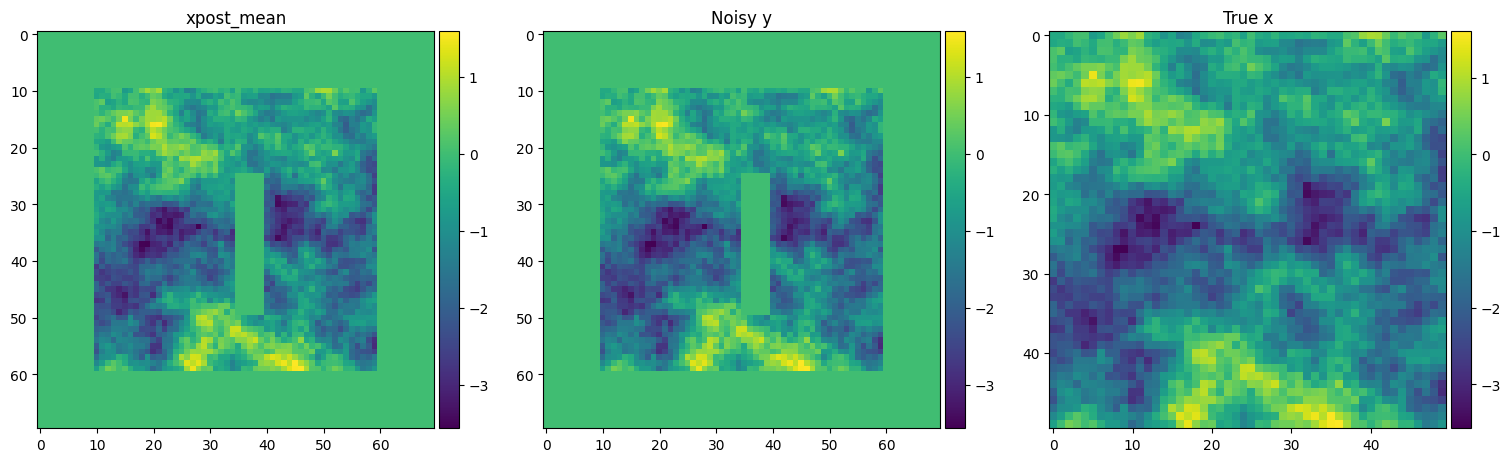

In [25]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(xpost_mean.reshape(H, W))
axes[0].set_title("xpost_mean")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

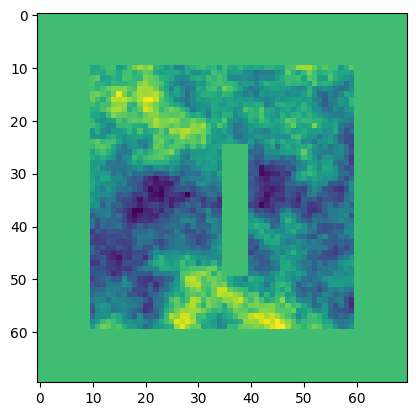

In [26]:
x_ = jnp.where(mask == 0, xpost_mean, 0)
plt.imshow(x_.reshape((H, W)))
plt.show()

## Posterior samples to compute the posterior marginal variances

In [ ]:
nb_samples = 50

dgmrf = eqx.combine(params_final["dgmrf"], static["dgmrf"])

key, subkey = jax.random.split(key, 2)
x_post_samples = dgmrf.posterior_samples(nb_samples, y, params_final["log_sigma"], subkey, x0=xpost_mean)

In [ ]:
fig, axes = plt.subplots(1, 10)
fig.set_size_inches(18.5, 10.5)

for i, ax in enumerate(axes):
    ax.imshow(x_post_samples[i].reshape(H, W))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

### Simple MC estimator

In [ ]:
var_x_post_samples = jnp.var(x_post_samples, axis=0)
plt.imshow(var_x_post_samples.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()

### Simple Rao-Blackwellized Monte Carlo

In [ ]:
var_x_post_samples_RBMC = dgmrf.rbmc_variance(x_post_samples, params_final["log_sigma"])

In [ ]:
plt.imshow(var_x_post_samples_RBMC.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()